<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

---
В ходе первичного ознакомления и дальнейшего анализа данных необходимо:
- загрузить и визуально оценить состав данных на примере нескольких семплов;
- посмотреть общую сводную информацию по набору данных: тип колонок, количество элементов и наличие пропусков и т.п.;
- оценить статистические параметры выборки;
- исследовать выбросы и аномальные значения
- исследовать на наличие явных/неявных дубликатов;
- оценить признаки и их взаимное влияние друг на друга;
- оценить сбалансированность выборки.

В этом же разделе, после оценки данных и ознакомления с ними:
- очистим данные при необходимости;
- удалим ненужные, по нашему мнению, колонки данных;
- закодируем методом OHE категориальные колонки; 
- разделим на обучающую и тестовую выборки;
- обучим scaler и imputer, заполним пропуски и отмасштабируем данные.

После этих процедур можно переходить к обучению и оценки различных моделей.

In [1]:
# нужно апгрейднуть библиотеку, низкая версия, в которой нет IterativeImputer
!pip install scikit-learn -U

     |████████████████████████████████| 10.9 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 104.3 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import sklearn
sklearn.__version__

'1.3.2'

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import sklearn

from sklearn.experimental import enable_iterative_imputer

from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler

from sklearn.preprocessing import FunctionTransformer

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc


from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier

from sklearn.metrics import make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

from sklearn.utils import shuffle

import re

In [4]:
df = pd.read_csv("/datasets/Churn.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


сразу приведем данные к необходимым типам данных:

In [6]:
df.HasCrCard, df.IsActiveMember = [x.astype('bool') for x in [df.HasCrCard, df.IsActiveMember]]
df.Geography, df.Gender  = [x.astype('category') for x in [df.Geography, df.Gender]]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   RowNumber        10000 non-null  int64   
 1   CustomerId       10000 non-null  int64   
 2   Surname          10000 non-null  object  
 3   CreditScore      10000 non-null  int64   
 4   Geography        10000 non-null  category
 5   Gender           10000 non-null  category
 6   Age              10000 non-null  int64   
 7   Tenure           9091 non-null   float64 
 8   Balance          10000 non-null  float64 
 9   NumOfProducts    10000 non-null  int64   
 10  HasCrCard        10000 non-null  bool    
 11  IsActiveMember   10000 non-null  bool    
 12  EstimatedSalary  10000 non-null  float64 
 13  Exited           10000 non-null  int64   
dtypes: bool(2), category(2), float64(3), int64(6), object(1)
memory usage: 820.7+ KB


In [8]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000,1.000000


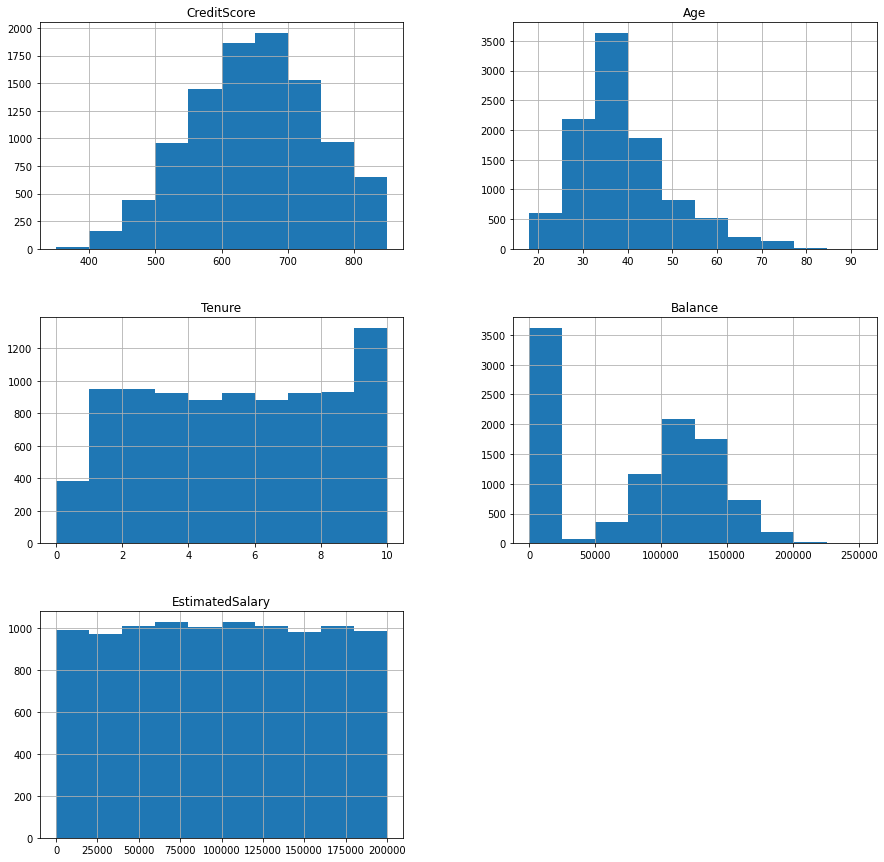

In [9]:
num_col_viz = [x for x in df.select_dtypes(include='number').columns.to_list() if x not in ['NumOfProducts', 'Exited',
                                                                                           'RowNumber', 'CustomerId']]

df.hist(column=num_col_viz, figsize=(15,15))
plt.show()

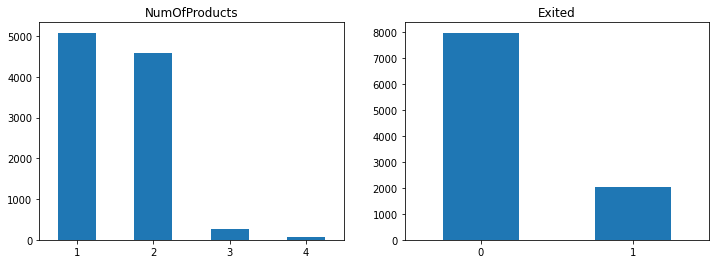

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

df.NumOfProducts.value_counts().plot(ax=axes[0], kind='bar', rot=0)
df.Exited.value_counts().plot(ax=axes[1], kind='bar', rot=0)
axes[0].set_title('NumOfProducts')
axes[1].set_title('Exited')
plt.show()

In [9]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

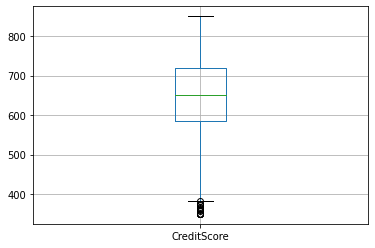

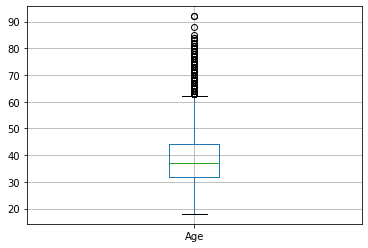

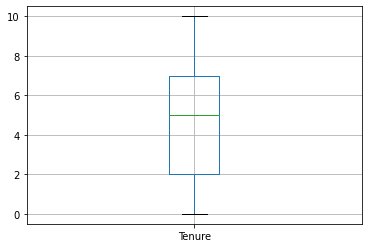

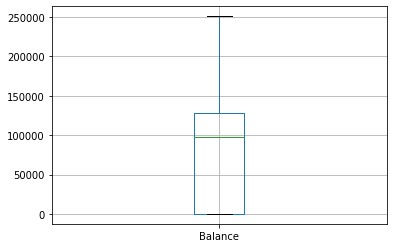

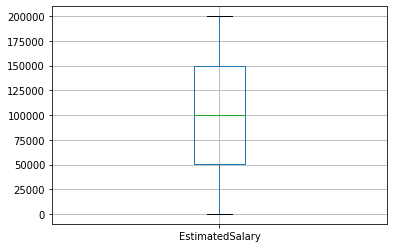

In [10]:
for col in ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']:
    df.boxplot(column=col)
    plt.show()

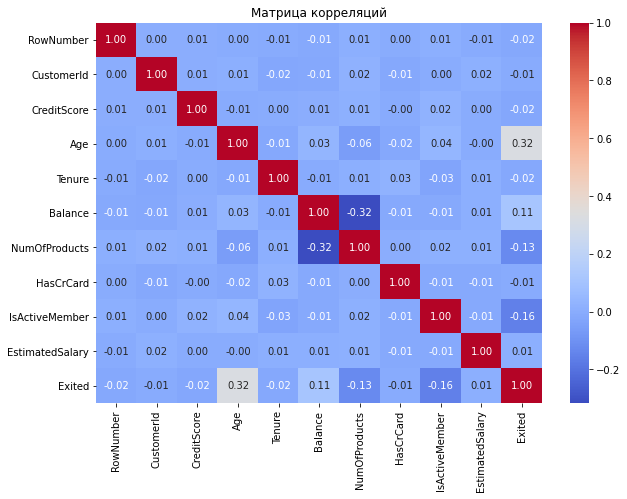

In [53]:
corr_matrix = df.corr(method='spearman')
plt.figure(figsize=(10,7))
sns.heatmap(data=corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

In [12]:
print(f'''
====================================================
Количество яных дубликатов: {df.duplicated().sum()}
====================================================
''')


Количество яных дубликатов: 0



In [13]:
print('=========================================')
print(f'Количество неуникальных номеров строк: {df.RowNumber.__len__() - df.RowNumber.unique().__len__()}')
print('=========================================')
print(f'Количество неуникальных идентификаторов пользователя: {df.CustomerId.__len__() - df.CustomerId.unique().__len__()}')
print('=========================================')
print(f'Количество уникальных фамилий: {df.Surname.unique().__len__()}')
print('=========================================')
print(f'Перечень локаций: {df.Geography.unique().tolist()}')
print('=========================================')
print(f'Перечень полов: {df.Gender.unique().tolist()}')

Количество неуникальных номеров строк: 0
Количество неуникальных идентификаторов пользователя: 0
Количество уникальных фамилий: 2932
Перечень локаций: ['France', 'Spain', 'Germany']
Перечень полов: ['Female', 'Male']


---
Проверка на явные дубликаты дала нулевой результат. Это хороший показатель, однако могут присутствовать неявные дубликаты, обычно появляющиеся в результате ошибок человека или системы, например неверное написание фамилии или повторные выгрузки с ошибками.  
Для проверки, мы посмотрели на количество неуникальных значений номеров строк и id пользователей. Повторных значений нет, все строки и пользователи уникальны.  
Количество уникальных фамилий составляет примерно 1/3 от всех пользователей. Это наталкивает на мысль, что возможно, могут быть ошибки в фамилии (или артефакты выгрузки, типа знаков подчеркиваний или пробелов), а механизмы присвоения RowNumber и CustomerId нам доподлино неизвестны. Таким образом, тут могут появиться неявные дубликаты.  
Неявных дубликатов, полученных на основе остальных колонок, таких как локация или пол, не может быть - они прописаны без ошибок, дублирований и однозначно.

In [14]:
print(f'''
====================================================
Количество неяных дубликатов: {df.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1).duplicated().sum()}
====================================================
''')


Количество неяных дубликатов: 0



В итоге, можно сделать вывод - неявных дубликатов нет.

---
Однако, этот анализ дал нам яное понимание, что такие колонки как 'Surname', 'RowNumber', 'CustomerId' - не имеют ценности для прогностической модели, т.е. не несут некоторой информации о пользователе, которая призвана помочь разделить их по целевому признаку. По сути являясь категориальными, эти признаки уникальны для каждого семпла, что делает их нецелесообразным для дальнейшего использования.

А вот такие признаки, как локация и пол - вполне могут оказаться полезными для моделй. Их необходимо перевести в бинарные признаки методом One Hot Encoding.

In [15]:
remained, gone = df.Exited.value_counts(normalize=True)*100
print(f"""
==========================
Процент пользователей, оставшихся клиентами банка: {remained:.2f}%;
===
Процент пользователей, отказавшихся от услуг банка: {gone:.2f}%.
==========================
""")


Процент пользователей, оставшихся клиентами банка: 79.63%;
===
Процент пользователей, отказавшихся от услуг банка: 20.37%.



Присутствуют пропуски в Tenure. Будут обработаны в рамках пайплайна. Для этого будет использован IterativeImputer, который заполняет пропуски на основе оценивания непропущенных значений остальных признаков каждого из семплов в сравнении со всеми семплами в выборке.

---
---

Таким образом:
- рассмотрено распределение данных - большинство из которых не является нормальным, некоторые является смещенными вправо.
- расмотрены диаграммы размаха. Ряд параметров имеют выбросы по IQR (межквантильному размаху). Однако, это достаточно распространенная ситуация в такого рода данных и не может являться прямым указанием на аномалии в данных. Данные выбросы можно обработать с ипользованием средств масштабирования, ориентированных на преобразование данных исходя из значений IQR, таких как RobustScaler.
- рассмотрена матрица корреляций. Линейной зависимости в данных не наблюдается. Это может быть не самым позитивным показателем, т.к. зависимости между входными переменными и таргетом в таком случае являются нелинейными, если они вообще есть. Это может усложнить работу классификатора, и этот факт необходимо учитывать при выборе модели для обучения.
- дубликатов нет. Более подробный анализ представлен выше.
- наблюдается дисбаланс классов - семплов положительного класса всего 20% от всего набора данных.

In [55]:
class_counts = df.Exited.value_counts()

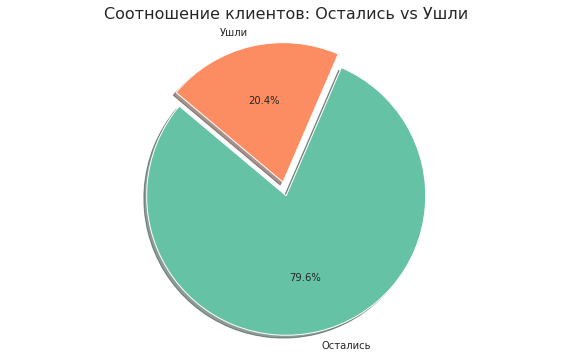

In [57]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
colors = sns.color_palette("Set2")

explode = (0.1, 0)
plt.pie(class_counts, labels=['Остались', 'Ушли'], autopct='%1.1f%%', startangle=140, explode=explode, colors=colors, shadow=True)

plt.title('Соотношение клиентов: Остались vs Ушли', fontsize=16)
plt.axis('equal')

plt.show()

---
В начале были обозначены задачи на обработку данных, и в текущий момент, описанные действия остаются актуальными.  
Для предобработки данных сформируем его пайплайн. Также удалим неинформативные колонки - 'Surname', 'RowNumber', 'CustomerId'.

In [61]:
df = df.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower())
df.head(1)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.0,1,True,True,101348.88,1


In [63]:
X, y = df.drop(['surname', 'row_number', 'customer_id', 'exited'], axis=1), df.exited

In [64]:
cat_cols = X.select_dtypes(include='category').columns.to_list()
num_cols = X.select_dtypes(include='number').columns.to_list()
bool_cols = X.select_dtypes(include='bool').columns.to_list()

In [76]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.4, random_state=12345, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=12345, stratify=y_tmp)

In [77]:
numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=12345)),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

noop_transformer = FunctionTransformer()
bool_transformer = Pipeline(steps=[
    ('noop', noop_transformer)
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cat_cols),
    ('num', numeric_transformer, num_cols),
    ('bool', bool_transformer, bool_cols)
])

 В данном блоке мы:
 - заполнили пропуски
 - отмасштабировали числовые параметры
 - категориальные перевели в булевы методом горячего кодирования
 - булевы колонки не трансформировали.  
 
Использование пайплайна и колумн трансформера очень удобно, потому что в одном месте собраны все препроцессовые функции для данных, мы их видем и можем проще и быстрее контролиировать. Также, он имеет методы fit и predict, и он понимает, какие трансформации можно применять в трейне, но нельзя к тесту.

## Исследование задачи

In [78]:
def model_eval(y_val, predictions):
    # Оценка модели
    f1 = f1_score(y_val, predictions)
    conf_matrix = confusion_matrix(y_val, predictions)

    print(f'F1 Score: {f1}')
#     print(f'Confusion Matrix:\n{conf_matrix}')
    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot()
    plt.show()
    precision, recall, f1, support = precision_recall_fscore_support(y_val, predictions)

    # Вывести метрики для каждого класса
    for i in range(len(precision)):
        print(f"Class {i}: Precision: {precision[i]}, Recall: {recall[i]}, F1-Score: {f1[i]}, Support: {support[i]}")

In [79]:
clf = RandomForestClassifier(random_state=12345)

pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classofier', clf)
])

F1 Score: 0.547112462006079


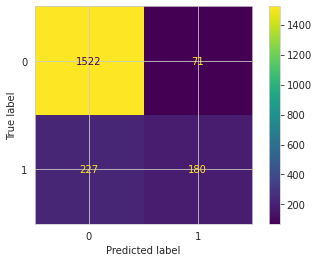

Class 0: Precision: 0.8702115494568324, Recall: 0.9554300062774639, F1-Score: 0.9108318372232195, Support: 1593
Class 1: Precision: 0.7171314741035857, Recall: 0.44226044226044225, F1-Score: 0.547112462006079, Support: 407


In [80]:
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_val)
model_eval(y_val, predictions)

В задаче не сказано, как необходимо усреднять f1 по классам, поэтому будем ориентироваться на настройки по умолчанию - ориентироваться на бинарное усреднение, т.е. это значение f1 по целевому классу.
Модель из "коробки" нам выдает результат 0.54 по f1, а в задании метрика должна быть не меньше 0.59. Это результат не оптимизированной по гиперпараметрам и несбалансированной по выборке модели.

Давайте проверим еще 2 модели из "коробки" - это логистическая регрессия и catboost.

========= метрики для LogisticRegression(random_state=12345)
F1 Score: 0.2932330827067669


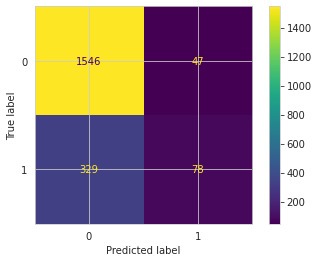

Class 0: Precision: 0.8245333333333333, Recall: 0.970495919648462, F1-Score: 0.8915801614763552, Support: 1593
Class 1: Precision: 0.624, Recall: 0.19164619164619165, F1-Score: 0.2932330827067669, Support: 407
========= метрики для <catboost.core.CatBoostClassifier object at 0x7fb513d50b20>
F1 Score: 0.5662100456621003


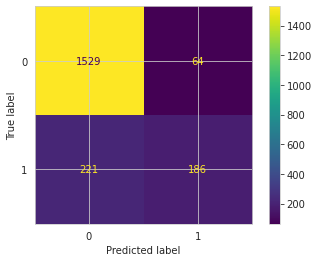

Class 0: Precision: 0.8737142857142857, Recall: 0.9598242310106717, F1-Score: 0.9147472330242298, Support: 1593
Class 1: Precision: 0.744, Recall: 0.457002457002457, F1-Score: 0.5662100456621003, Support: 407


In [82]:
clfs = [LogisticRegression(random_state=12345), CatBoostClassifier(verbose=False, task_type='CPU', random_state=12345)]
for clf_tmp in clfs:
    
    pipeline_tmp = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('classofier', clf_tmp)
    ])
    print(f'========= метрики для {clf_tmp}')
    pipeline_tmp.fit(X_train, y_train)
    predictions_tmp = pipeline_tmp.predict(X_val)
    model_eval(y_val, predictions_tmp)

F1 Score: 0.5662100456621003
ROC AUC Score: 0.8600033006812668


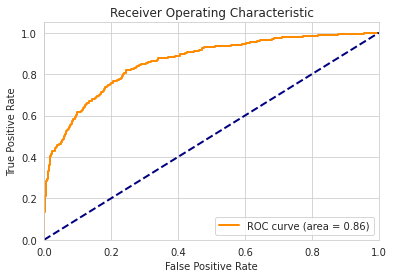

In [83]:
probabilities = pipeline_tmp.predict_proba(X_val)[:, 1] # вероятности для класса 1
f1 = f1_score(y_val, predictions_tmp)
roc_auc = roc_auc_score(y_val, probabilities)
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

# Расчет кривой ROC
fpr, tpr, thresholds = roc_curve(y_val, probabilities)
roc_auc = auc(fpr, tpr)

# Построение кривой ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

---
Такое значение ROC AUC отражает хорошую прогностическую способность модели по сравнению со случайной. Однако потенциал для улучшения модели присутствует, т.к полнота на целевом классе достаточно низкая.

In [40]:
# !pip install optuna

     |████████████████████████████████| 409 kB 1.1 MB/s eta 0:00:01


---
Попробуем найти субоптимальные (т.к. поиск в заданном пространстве за заданное кол-во итераций) значения гиперпараметров для модели, которая из "коробки" показала лучший результат - CatBoost.

Для этого можно пользоваться различными инструментами, но библиотека для такой оптимизации - optuna - является хорошим выбором, на наш взгляд.

In [44]:
# import optuna

In [45]:
# # Функция для создания оценщика F1-меры с микро усреднением
# f1_scorer = make_scorer(f1_score, average='binary')

# catboost_clf = catboost_clf = CatBoostClassifier(task_type="CPU",
#                                   verbose=False, random_seed=12345)
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', catboost_clf)
#   ])

# def objective(trial):
#     # Гиперпараметры для настройки
#     iterations = trial.suggest_int('iterations', 300, 3000)
#     learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
#     depth = trial.suggest_int('depth', 1, 8)
#     l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1.,100.)
#     auto_class_weights=trial.suggest_categorical("auto_class_weights", ["Balanced", "SqrtBalanced", "None"])
#     random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True)
#     bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0)
#     od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"])
#     od_wait=trial.suggest_int("od_wait", 10, 50)



#     # Обновляем пайплайн новыми гиперпараметрами
#     pipeline.set_params(classifier__iterations=iterations,
#                         classifier__learning_rate=learning_rate,
#                         classifier__depth=depth,
#                         classifier__auto_class_weights=auto_class_weights,
#                         classifier__l2_leaf_reg=l2_leaf_reg,
#                         classifier__random_strength=random_strength,
#                         classifier__bagging_temperature=bagging_temperature,
#                         classifier__od_type=od_type,
#                         classifier__od_wait=od_wait)

#     # Выполняем кросс-валидацию и возвращаем среднюю F1-меру
#     scores = cross_val_score(pipeline, X_train, y_train, n_jobs=1, cv=3, scoring=f1_scorer)
#     return scores.mean()

# # Создаем исследование (study) и оптимизируем F1-меру
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# # Выводим лучшие параметры
# print(study.best_params)

[I 2023-11-30 23:26:02,696] A new study created in memory with name: no-name-57a8a83d-fa29-4b01-8ea8-92a5ed358f45
[I 2023-11-30 23:26:08,911] Trial 0 finished with value: 0.560843428120643 and parameters: {'iterations': 778, 'learning_rate': 0.001514072404768726, 'depth': 3, 'l2_leaf_reg': 70.89144851394386, 'auto_class_weights': 'Balanced', 'random_strength': 4.610843746288073e-05, 'bagging_temperature': 2.277373214164029, 'od_type': 'Iter', 'od_wait': 32}. Best is trial 0 with value: 0.560843428120643.
[I 2023-11-30 23:26:29,328] Trial 1 finished with value: 0.5297980847798902 and parameters: {'iterations': 2450, 'learning_rate': 1.2248814785005121e-05, 'depth': 6, 'l2_leaf_reg': 60.41721901059388, 'auto_class_weights': 'None', 'random_strength': 1.6895895788185675e-06, 'bagging_temperature': 9.89198948893247, 'od_type': 'IncToDec', 'od_wait': 14}. Best is trial 0 with value: 0.560843428120643.
[I 2023-11-30 23:26:35,689] Trial 2 finished with value: 0.5243099150505324 and parameters

{'iterations': 2564, 'learning_rate': 0.004238642797418927, 'depth': 4, 'l2_leaf_reg': 16.10483871000087, 'auto_class_weights': 'SqrtBalanced', 'random_strength': 0.7871780792528231, 'bagging_temperature': 0.007801378108428292, 'od_type': 'Iter', 'od_wait': 28}


Запуск на поиск гиперпараметров позволил нам увеличить метрику на 1.6% - и это на кросс-валидации.  
Получены следующие значения для модели:  
{'iterations': 2564, 'learning_rate': 0.004238642797418927, 'depth': 4, 'l2_leaf_reg': 16.10483871000087, 'auto_class_weights': 'SqrtBalanced', 'random_strength': 0.7871780792528231, 'bagging_temperature': 0.007801378108428292, 'od_type': 'Iter', 'od_wait': 28}

## Борьба с дисбалансом

По сути, нам оптуна уже нашла оптимальный параметр балансировки - корень коэффициентов баланса (SQRTBalanced).

================== модель Catboost, auto_class_weights_options: Balanced===========================
F1 Score: 0.6067864271457085


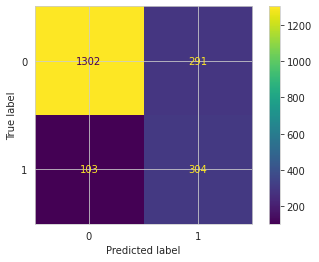

Class 0: Precision: 0.9266903914590747, Recall: 0.8173258003766478, F1-Score: 0.8685790527018011, Support: 1593
Class 1: Precision: 0.5109243697478991, Recall: 0.7469287469287469, F1-Score: 0.6067864271457085, Support: 407
================== модель Catboost, auto_class_weights_options: None===========================
F1 Score: 0.5457364341085271


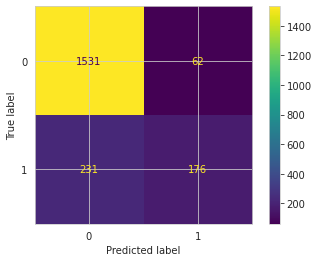

Class 0: Precision: 0.8688989784335982, Recall: 0.9610797237915882, F1-Score: 0.9126676602086439, Support: 1593
Class 1: Precision: 0.7394957983193278, Recall: 0.43243243243243246, F1-Score: 0.5457364341085271, Support: 407
================== модель Catboost, auto_class_weights_options: SqrtBalanced===========================
F1 Score: 0.6190476190476191


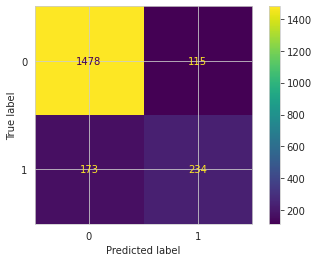

Class 0: Precision: 0.8952150211992732, Recall: 0.9278091650973007, F1-Score: 0.9112207151664612, Support: 1593
Class 1: Precision: 0.670487106017192, Recall: 0.5749385749385749, F1-Score: 0.6190476190476191, Support: 407


In [85]:
common_params = {
    'verbose': False,
    'task_type': 'CPU',
    'random_state': 12345,
    'iterations': 2564,
    'learning_rate': 0.004238642797418927,
    'depth': 4,
    'l2_leaf_reg': 16.10483871000087,
    'random_strength': 0.7871780792528231,
    'bagging_temperature': 0.007801378108428292,
    'od_type': 'Iter',
    'od_wait': 28
}

auto_class_weights_options = ['Balanced', None, 'SqrtBalanced']

for weight_option in auto_class_weights_options:
    params = common_params.copy()
    params['auto_class_weights'] = weight_option
    clf = CatBoostClassifier(**params)

    pipeline = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('classofier', clf)
    ])
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_val)
    print(f"================== модель Catboost, auto_class_weights_options: {weight_option}===========================")
    model_eval(y_val, predictions)

На исходной тестовой выборке f1 составил 61.9%. Важно то, что простая балансировка и отсутствие какой-либо балансировки дает хуже результат и метрика падает.

--- 

Вероятно этот подход к балансировке дает наилучший результат. Однако проверим тахнологии оверсемплинга и даунсумплинга. Хорошим решением было бы использовать специализированные для этого библиотеки, например - imblearn.over_sampling, imblearn.under_sampling. Они хороши тем, что их можно интегрировать в пайплайн sklearn, точнее сделать над ним обертку imblearn-ом.  
Но в текущей работе проделаем это вручную для закрепления пройденного материала.

In [105]:
def downsampling(features, target):
    """Функция уменьшения размеров отрицательного класса до количества семплов положительного.
    не оптимизирована на случаи, если положительного больше, чем отрицательного и т.п. т.к. работаем
    с конкретным случаем."""
    features_ones = features[target == 1]
    features_zeros = features[target == 0]
    target_ones = target[target == 1]
    target_zeros = target[target == 0]
    
    features_ds = pd.concat(
        [features_zeros.sample(n=len(target_ones), random_state=12345)] + [features_ones]
    )
    target_ds = pd.concat(
        [target_zeros.sample(n=len(target_ones), random_state=12345)] + [target_ones]
    )
    
    features_ds, target_ds = shuffle(features_ds, target_ds, random_state=12345)
    
    return features_ds, target_ds

In [106]:
X_trainds, y_trainds = downsampling(X_train, y_train)

In [107]:
import numpy as np

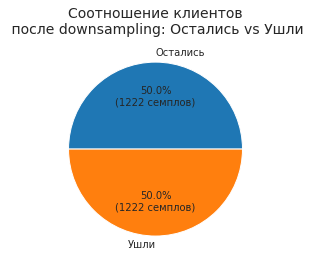

In [116]:
class_counts = y_trainds.value_counts()
plt.pie(class_counts, labels=['Остались', 'Ушли'], autopct=lambda p: '{:.1f}%\n({:d} семплов)'.format(p, int(p/100*sum(class_counts))))
plt.title('Соотношение клиентов\n после downsampling: Остались vs Ушли', fontsize=14)
plt.show()

================== модель Catboost c downsampling===========================
F1 Score: 0.6066985645933014


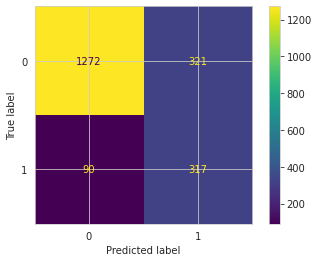

Class 0: Precision: 0.933920704845815, Recall: 0.7984934086629002, F1-Score: 0.8609137055837564, Support: 1593
Class 1: Precision: 0.49686520376175547, Recall: 0.7788697788697788, F1-Score: 0.6066985645933014, Support: 407


In [109]:
pipeline.fit(X_trainds, y_trainds)
predictions = pipeline.predict(X_val)
print(f"================== модель Catboost c downsampling===========================")
model_eval(y_val, predictions)

In [110]:
def oversampling(features, target):
    """Функция увеличения посредством повторения размеров положительного класса до количества семплов отрицательного.
    не оптимизирована на случаи, если положительного больше, чем отрицательного и т.п. т.к. работаем
    с конкретным случаем."""
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    repeat = len(features_zeros) // len(features_ones)

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = sklearn.utils.shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [111]:
X_trainos, y_trainos = oversampling(X_train, y_train)

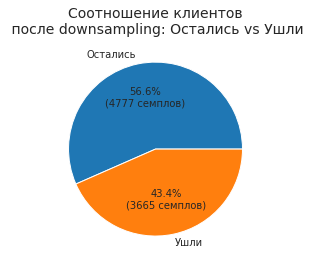

In [117]:
class_counts = y_trainos.value_counts()
plt.pie(class_counts, labels=['Остались', 'Ушли'], autopct=lambda p: '{:.1f}%\n({:d} семплов)'.format(p, int(p/100*sum(class_counts))))
plt.title('Соотношение клиентов\n после downsampling: Остались vs Ушли', fontsize=14)
plt.show()

================== модель Catboost c oversampling===========================
F1 Score: 0.6228813559322033


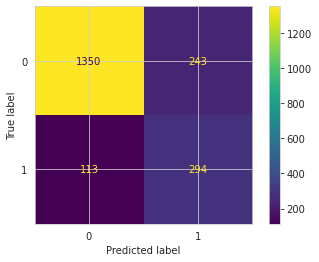

Class 0: Precision: 0.9227614490772386, Recall: 0.847457627118644, F1-Score: 0.8835078534031413, Support: 1593
Class 1: Precision: 0.547486033519553, Recall: 0.7223587223587223, F1-Score: 0.6228813559322033, Support: 407


In [118]:
pipeline.fit(X_trainos, y_trainos)
predictions = pipeline.predict(X_val)
print(f"================== модель Catboost c oversampling===========================")
model_eval(y_val, predictions)

---
Предположение о том, что модель использует уже оптимальный метод балансировки, найденный в рамках поиска гиперпараметров, оказалось верным. Ни даунсемплинг (или андерсемплинг), ни оверсемлинг (или апсемплинг) не дали результата, ухудшив метрики модели. 

## Тестирование модели

================== модель Catboost ===========================
F1 Score: 0.6616352201257862


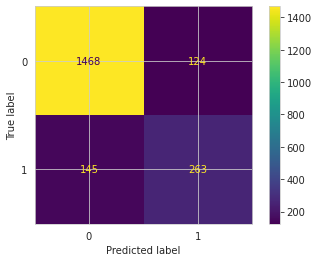

Class 0: Precision: 0.9101053936763794, Recall: 0.9221105527638191, F1-Score: 0.9160686427457098, Support: 1592
Class 1: Precision: 0.6795865633074936, Recall: 0.6446078431372549, F1-Score: 0.6616352201257862, Support: 408


In [120]:
# еще раз повторим лучший вариант модели
common_params = {
    'verbose': False,
    'task_type': 'CPU',
    'random_state': 12345,
    'iterations': 2564,
    'learning_rate': 0.004238642797418927,
    'depth': 4,
    'l2_leaf_reg': 16.10483871000087,
    'random_strength': 0.7871780792528231,
    'bagging_temperature': 0.007801378108428292,
    'od_type': 'Iter',
    'od_wait': 28,
    'auto_class_weights': 'SqrtBalanced'
    
}

clf = CatBoostClassifier(**params)

pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classofier', clf)
])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(f"================== модель Catboost ===========================")
model_eval(y_test, predictions)

Посмотрим насколько изменилась ROC AUC.

F1 Score: 0.22418136020151133
ROC AUC Score: 0.8673079859520538


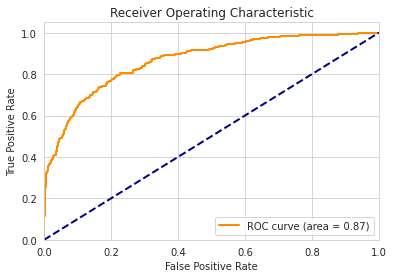

In [121]:
probabilities = pipeline.predict_proba(X_val)[:, 1] # вероятности для класса 1
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_val, probabilities)
print(f'F1 Score: {f1}')
print(f'ROC AUC Score: {roc_auc}')

# Расчет кривой ROC
fpr, tpr, thresholds = roc_curve(y_val, probabilities)
roc_auc = auc(fpr, tpr)

# Построение кривой ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Работа с балансом классов не сильно повлиял на эту метрику. Если f1 от балансировки подросла на 6%, то ROC AUK изменялась на 0.7%.

## Вывод

В работу получены банковские данные по клиентам компании. Эти данные содержат информацию о поведении пользователя в рамках услуг банка. Среди параметров, описывающих клиента, есть информация о качестве и количестве используемых услуг, интенсивности и объемах вовлеченности пользователя, а также о итоговом решении клиента пользоваться или отказаться от услуг банка. Этот последний параметр является целевым, и наша задача разработать алгоритм классификации, который способен отличить первых от вторых с некоторой достаточной вероятностью. Метрикой правильности работы модели является f1 мера, которая является среднегармоническим между точностью и полнотой классификации модели.  

Был проведен первичный анализ и ознакомление с данными, который включал в себя следующий порядок:

- загрузка и визуальная оценка состава данных на примере нескольких семплов;
- посмотр общей сводной информации по набору данных: тип колонок, количество элементов и наличие пропусков и т.п.;
- оценка статистических параметров выборки;
- исследование выбросов и аномальных значений;
- исследование на наличие явных/неявных дубликатов;
- оценка признаков и их взаимного влияние друг на друга;
- оценка сбалансированности выборки.

По итогу первичного анализа сделаны следующие выводы:

- рассмотрено распределение данных - большинство из которых не является нормальным, некоторые является смещенными вправо.
- расмотрены диаграммы размаха. Ряд параметров имеют выбросы по IQR (межквантильному размаху). Однако, это достаточно распространенная ситуация в такого рода данных и не может являться прямым указанием на аномалии в данных. Данные выбросы можно обработать с ипользованием средств масштабирования, ориентированных на преобразование данных исходя из значений IQR, таких как RobustScaler.
- рассмотрена матрица корреляций. Линейной зависимости в данных не наблюдается. Это может быть не самым позитивным показателем, т.к. зависимости между входными переменными и таргетом в таком случае являются нелинейными, если они вообще есть. Это может усложнить работу классификатора, и этот факт необходимо учитывать при выборе модели для обучения.
- дубликатов нет ни явных ни неявных.
- наблюдается дисбаланс классов - семплов положительного класса всего 20% от всего набора данных.

Далее нам необходимо было проделать следующие шаги по подготовке обучабщего и тестового набора данных:
- очистим данные при необходимости;
- удалим ненужные, по нашему мнению, колонки данных;
- закодируем методом OHE категориальные колонки;
- разделим на обучающую и тестовую выборки;
- обучим scaler и imputer, заполним пропуски и отмасштабируем данные.

Для препроцессинга набора данных проделаны шаги, формирующие препроцессинг в составе будущего пайплайна. В рамках такого препроцессинга собраны следующие шаги:
- заполнили пропуски
- отмасштабировали числовые параметры
- категориальные перевели в булевы методом горячего кодирования
- булевы колонки не трансформировали.

Использование пайплайна и колумн трансформера очень удобно, потому что в одном месте собраны все препроцессовые функции для данных, мы их видем и можем проще и быстрее контролиировать. Также, он имеет методы fit и predict, и он понимает, какие трансформации можно применять в трейне, но нельзя к тесту.  
Далее представлена структурная схема препроцессига:

In [65]:
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Geography', 'Gender']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  IterativeImputer(random_state=12345)),
                                                 ('scaler', RobustScaler())]),
                                 ['CreditScore', 'Age', 'Tenure', 'Balance',
                                  'NumOfProducts', 'EstimatedSalary']),
                                ('bool',
                                 Pipeline(steps=[('noop',
                                                  FunctionTransformer())]),
                                 ['HasCrCard', 'IsActiveMember'])])

Для первичного обучения были выбраны 3 основные модели и применены "из коробки": логистическая регрессия, случайный лес, catBoost. Получены следующие показатели качества моделей по f1: 0,29 для логистической регрессии, 0.57 для случайного леса, 0.60 для catboost.  
Для дальнейшего анализа выбрана модель catboost, которую мы запустили для поиска её гиперпараметров. Полученная модель имеет показатель качества f1 в районе 0.66.  
Модель с оптимизированными гиперараметрами была прверена на несколько вариантов балансировки - поиск коэффициентов для семплов и их использование, взятие от этих коэффициентов кадратного корня, или оставить выборку не сбалансированной. В итоге, вариант, предложенный оптуной, с автоматической балансировкой корнем от весов (SQRTBalanced) является наиболее оптимальным.  
Была проведена дополнительная "ручная" балансировка выборки методами оверсемплинг и даунсемплинг, которые показали ухудшение исходных метрик catboost.  
Итоговая f1 мера полученной модели - 66%, что выше ожидаемой и требуемой по условию задачи - 59%.